In [65]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt


plt.rcdefaults()
plt.rcParams.update({
    "text.usetex": True, # set to False if you don't have LaTeX installed
    "font.family": "serif",
})

# initial temperature density dataset

In [66]:
df = pd.read_csv('temperature-intensity.csv')
T = df.iloc[:,1].to_numpy() # temperature
I = df.iloc[:,2].to_numpy() # intensity

# normalize data so that fitting is easier
T_norm = (T - np.mean(T))/np.std(T)
I_norm = (I - np.min(I))/np.std(I)
#I_norm = (I - np.mean(I))/np.std(I)

In [67]:
def sinc2_linear(x, A, x0, w, m, b):
    # sinc function + linear component
    # A = amplitude, x0 = center, w = width parameter, m = slope, b = offset
    arg = (x - x0) / w
    return A * np.sinc(arg)**2 + m * x + b

# np.sinc(x) = sin(pi*x)/(pi*x), FWHM of sinc ≈ 1.21 * w
# So w ≈ FWHM / 1.21 ≈ 1 / 1.21 ≈ 0.83
p0 = [3, 0.3, 0.83, 0, 0]

popt, pcov = curve_fit(sinc2_linear, T_norm, I_norm, p0=p0)

A, x0, w, m, b = popt
print(f"Amplitude: {A:.4f}")
print(f"Center:    {x0:.4f}")
print(f"Width:     {w:.4f}")
print(f"Slope:     {m:.4f}")
print(f"Offset:    {b:.4f}")

# Generate fitted curve
T_norm_fit = np.linspace(T_norm.min(), T_norm.max(), 500)
I_norm_fit = sinc2_linear(T_norm_fit, *popt)

Amplitude: 2.7923
Center:    0.2028
Width:     1.0109
Slope:     0.0267
Offset:    0.0394


Peak location: T=191.8784
Peak width: dT=6.1740


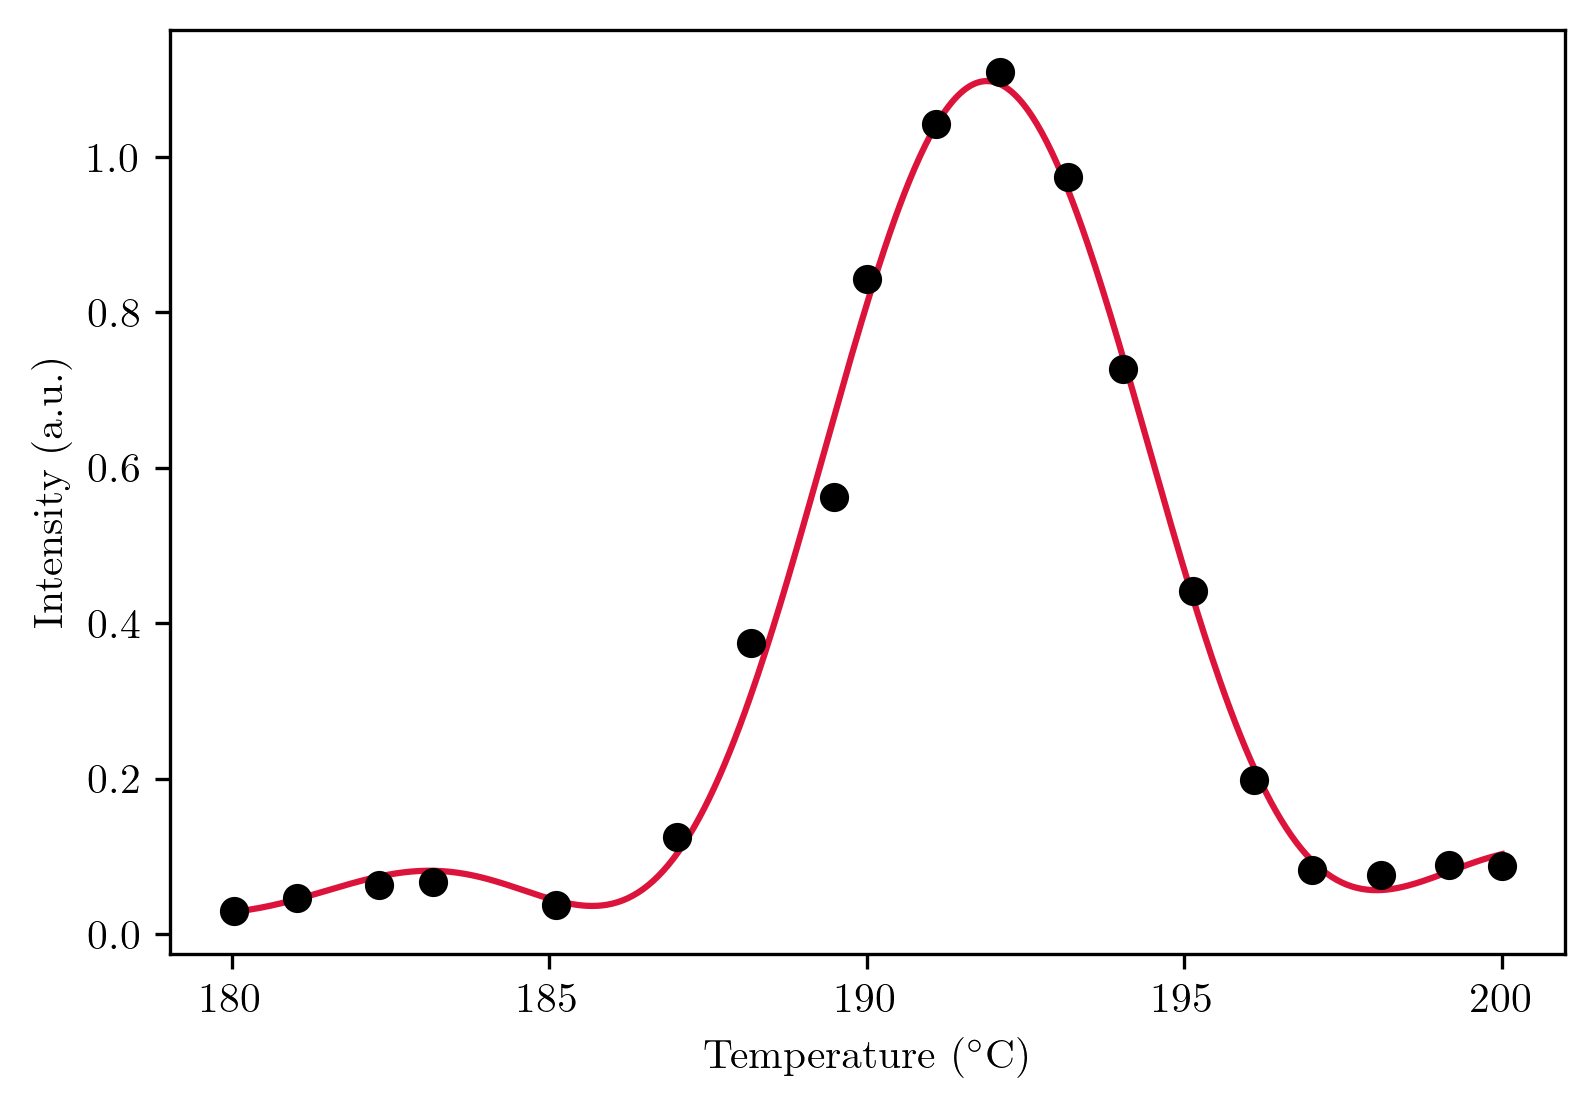

In [68]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300)

#ax.set_yscale('log')

T_fit = np.std(T)*T_norm_fit + np.mean(T)
I_fit = np.std(I)*I_norm_fit + np.min(I)

T0 = np.std(T)*x0 + np.mean(T)
T_width = np.std(T)*w

ax.plot(T_fit, I_fit, color='crimson', zorder=1)
ax.scatter(T, I, color='k', zorder=2)

ax.set_xlabel('Temperature ($^{\\circ}$C)')
ax.set_xticks([180, 185, 190, 195, 200])
ax.set_ylabel('Intensity (a.u.)')

print(f'Peak location: T={T0:.4f}')
print(f'Peak width: dT={T_width:.4f}')

plt.show()

# Obtaining Confidence Intervals

In [69]:
from lmfit import Model, conf_interval, conf_interval2d

In [70]:
sinc_model = Model(sinc2_linear)

params = sinc_model.make_params(A=3, 
                            x0=0.3, 
                            w=0.83,
                            m=0,
                            b=0)


# we will use this array  of points to evaluate the fit
T_norm_fit = np.linspace(T_norm.min(), T_norm.max(), 500)

# get the fit result
I_norm_fit_result = sinc_model.fit(I_norm, params, x=T_norm)

#evaluate fit at fine sweep of x values
I_norm_fit_eval = I_norm_fit_result.eval(x=T_norm_fit)

# ci = conf_interval(I_norm_fit_result, I_norm_fit_result, sigmas=[1,2,3])

pred_ci = I_norm_fit_result.eval_uncertainty(x=T_norm_fit, sigma=3)

# print(ci)

# transform from normalized data to raw
T_fit = np.std(T)*T_norm_fit + np.mean(T)

# NOTE! DOUBLE CHECK THAT THESE MAKE SENSE
I_fit_eval = np.std(I)*I_norm_fit_eval + np.min(I)
# I_fit_eval = np.std(I)*I_norm_fit_eval + np.mean(I)

I_ci_up = np.std(I)*(I_norm_fit_eval + pred_ci) + np.min(I)
I_ci_down = np.std(I)*(I_norm_fit_eval - pred_ci) + np.min(I)

<span style="color:red"> Change parameter background noise 

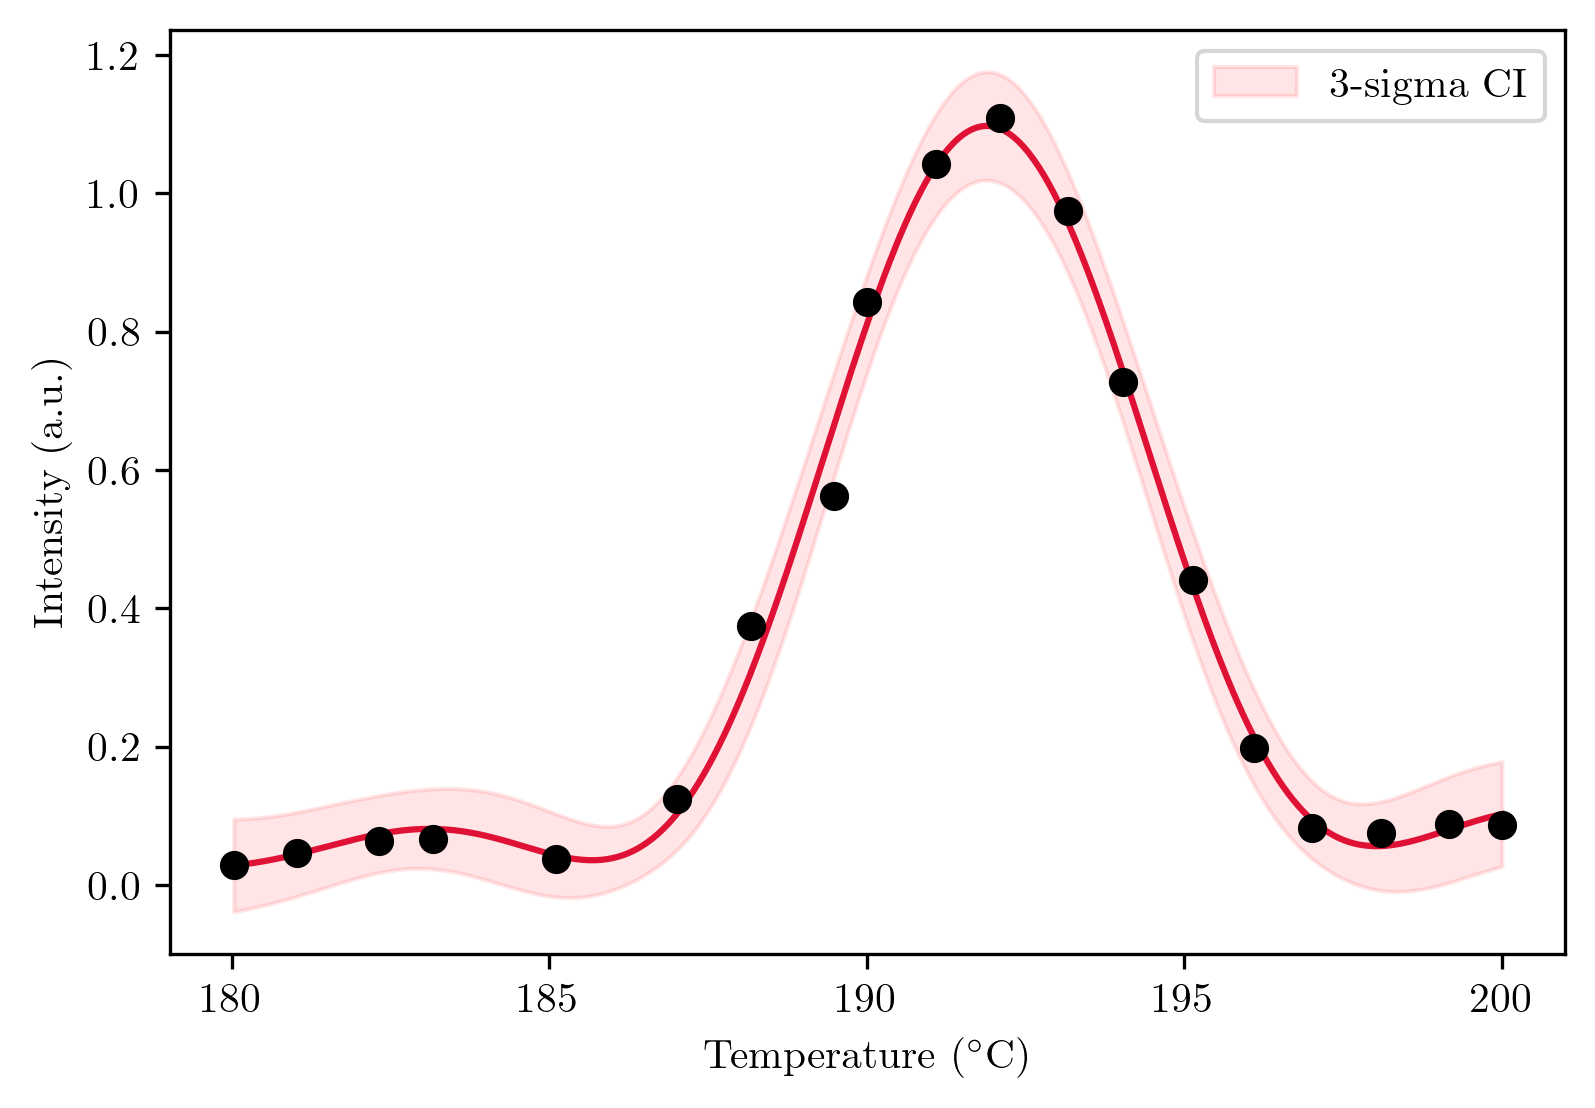

In [71]:
BACKGROUND_NOISE = 2e-3


fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.plot(T_fit, I_fit_eval, color='crimson', zorder=1)
# plt.errorbar(T, I, yerr=BACKGROUND_NOISE, fmt = 'none', capsize=5, zorder=3)
ax.scatter(T, I, color='k', zorder=2)
plt.fill_between(T_fit, I_ci_down, I_ci_up, 
                 color='red', alpha=0.1, label='3-sigma CI')

ax.set_xlabel('Temperature ($^{\\circ}$C)')
ax.set_xticks([180, 185, 190, 195, 200])
ax.set_ylabel('Intensity (a.u.)')

plt.legend()

Lets look at the confidence intervals of each of the parameters of the model

In [72]:
params = sinc_model.make_params(A=3, 
                            x0=0.3, 
                            w=0.83,
                            m=0,
                            b=0)

This code is adapted from the example array of parameter confidence interval contour plots here: "https://lmfit.github.io/lmfit-py/confidence.html#confidence-chapter"

# NEXT TASK: NORMALIZE THE CI INFO 

c:\Users\diyan\anaconda3\envs\simulation\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Generating chi-square map for ('A', 'x0')
Generating chi-square map for ('x0', 'w')
Generating chi-square map for ('w', 'A')


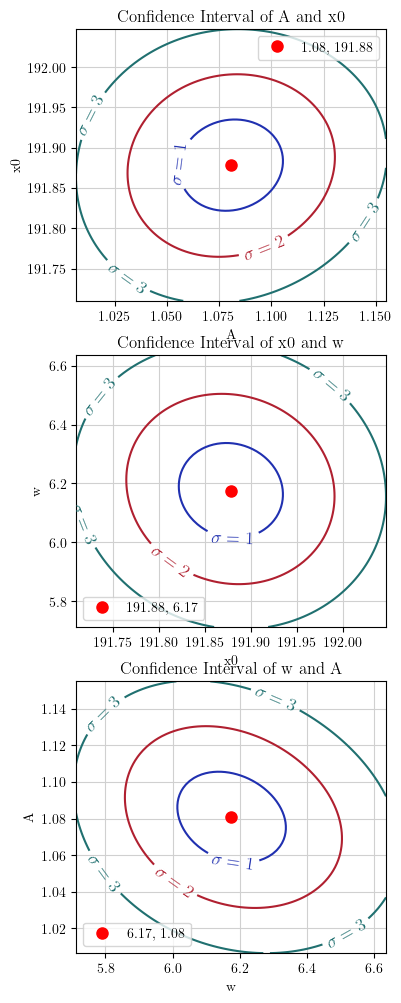

In [ ]:
explicitly_calculate_sigma = True
nsamples = 80

aix, aiy = 0, 0
colors = ('#2030b0', '#b02030', '#207070')
sigma_levels = [1,2,3]
fig, axes = plt.subplots(3, 1, figsize=(4, 12))
ci = conf_interval(I_norm_fit_result, I_norm_fit_result, sigmas=sigma_levels)

map_info = {'A': [np.min(I), np.std(I)], 
            'x0': [np.mean(T), np.std(T)], 
            'w': [0, np.std(T)]}

for pairs in (('A', 'x0'), ('x0', 'w'),
              ('w', 'A')):

    xpar, ypar = pairs
    
    if explicitly_calculate_sigma:
        print(f"Generating chi-square map for {pairs}")
        c_x, c_y, chi2_mat = conf_interval2d(I_norm_fit_result, I_norm_fit_result, xpar, ypar,
                                             nsamples, nsamples, nsigma=3,
                                             chi2_out=True)
        # explicitly calculate sigma matrix: sigma increases chi_square
        # from  chi_square_best
        # to    chi_square + sigma**2 * reduced_chi_square
        # so:   sigma = sqrt((chi2-chi2_best)/ reduced_chi_square)
        chi2_min = chi2_mat.min()
        sigma_mat = np.sqrt((chi2_mat-chi2_min)/I_norm_fit_result.redchi)
    else:
        print(f"Generating sigma map for {pairs}")
        # or, you could just calculate the matrix of probabilities as:
        c_x, c_y, sigma_mat = conf_interval2d(I_norm_fit_result, I_norm_fit_result, xpar, ypar,
                                              nsamples, nsamples, nsigma=3)

    

    # 1. Grab scaling factors for the current pair
    x_mean, x_std = map_info[xpar]
    y_mean, y_std = map_info[ypar]

    # 2. Reverse the transformation for the grid coordinates
    c_x_unnorm = (c_x * x_std) + x_mean
    c_y_unnorm = (c_y * y_std) + y_mean

    best_x = I_norm_fit_result.params[xpar].value
    best_y = I_norm_fit_result.params[ypar].value

    best_x_unnorm = (best_x * x_std) + x_mean
    best_y_unnorm = (best_y * y_std) + y_mean


    # aix += 1
    ax = axes[aiy]
    aiy += 1
    # if aix == 2:
    #     aix = 0
    #     aiy += 1
   

    cnt = ax.contour(c_x_unnorm, c_y_unnorm, sigma_mat, levels=sigma_levels, colors=colors,
                     linestyles='-')
    ax.clabel(cnt, inline=True, fmt=r"$\sigma=%.0f$", fontsize=13)
    ax.plot(best_x_unnorm, best_y_unnorm, 'ro', markersize=8, label=f'{best_x_unnorm:.2f}, {best_y_unnorm:.2f}') 

    
    ax.set_title(f"Confidence Interval of {xpar} and {ypar}")

    ax.set_xlabel(xpar)
    ax.set_ylabel(ypar)
    ax.grid(True, color='#d0d0d0')
    ax.legend()
plt.show()

# power vs temp

[np.float64(8.63713321e-10), np.float64(2.123182084e-09), np.float64(3.997021284e-09), np.float64(4.470794496000001e-09), np.float64(1.4364858009999997e-09), np.float64(1.56700324e-08), np.float64(1.40625e-07), np.float64(3.160800841e-07), np.float64(7.108850596000001e-07), np.float64(1.08722329e-06), np.float64(1.2312121599999998e-06), np.float64(9.501375625000001e-07), np.float64(5.281364928999999e-07), np.float64(1.945956769e-07), np.float64(3.92000401e-08), np.float64(6.868928640999999e-09), np.float64(5.7729604000000004e-09), np.float64(7.793711524e-09), np.float64(7.562389443999998e-09)]


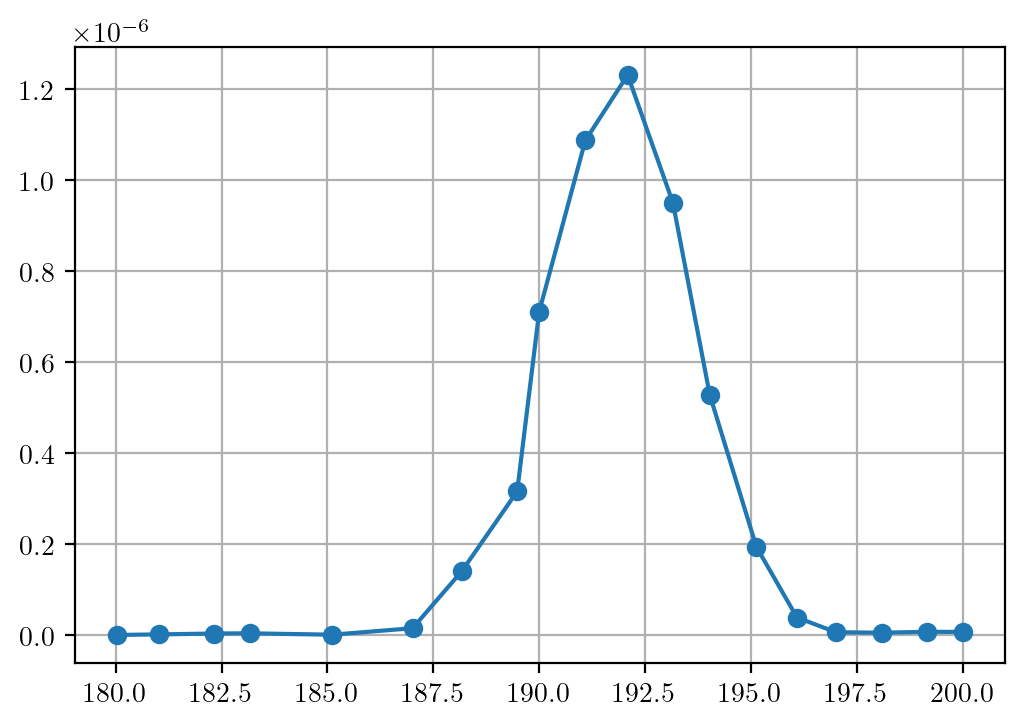

In [74]:
R = 1e6  # 1 MΩ scope input impedance

power_watts = [(v**2)/R for v in I]
print(power_watts)
#plot for power in watts
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
plt.plot(T, power_watts, marker='o')
# plt.xlabel("Temperature")
# plt.ylabel("Power (W)")
# plt.title("Power vs Temperature (1 MΩ Load)")
plt.grid(True)
# plt.xlim(180, 200)
# plt.xticks(range(180, 201, 1), fontsize=8)
plt.show()
